<a href="https://colab.research.google.com/github/MCannas/BusinessIntelligence/blob/master/1_1_8_2_Kalifornien_Hauspreise.ipynb%20at%20main%20%C2%B7%20christianwarmuth_openhpi-kipraxis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os # u.a. zur Entwicklugn plattformübergreifender Systempfade
import pandas as pd # Datenmanagement
import numpy as np # Hilfsfunktionen für mathematische Operationen

# Datenvisualisierung
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split # Datensplits
from sklearn.linear_model import LinearRegression # Machine Learning
from sklearn import metrics # Modellevaluierung

In [2]:
import os
import tarfile
import urllib.request
import shutil
import requests

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.getcwd()
CALIFORNIA_URL = "https://raw.githubusercontent.com/christianwarmuth/openhpi-kipraxis/main/images/california.png"
CALIFORNIA_PATH = "california.png"
FILE_PATH = "housing.csv"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

response = requests.get(CALIFORNIA_URL, stream=True)
with open(CALIFORNIA_PATH, 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

df = pd.read_csv(FILE_PATH) # Wir lesen die Datei housing.csv ein

df = df.dropna() # löscht alle Zeile mit fehlenden Attributen
df = df.reset_index(drop=True) # zählt unsere Daten neu durch

description = df.describe()

bins = [0] + list(description["median_house_value"][
    ["25%", "50%", "75%"]
].astype(int)) + [np.inf]

df["house_cat"] = pd.cut(
    df["median_house_value"],
    bins=bins,
    labels=["0 - 25%", "25 - 50%", "50 - 75%", "75 - 100%"]
)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for train_index, test_index in split.split(df, df["house_cat"]):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]

df_train = df_train.drop("house_cat", axis=1)
df_test = df_test.drop("house_cat", axis=1)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_df_on_california(df, california_path):

    ax = df.plot(
        kind="scatter",
        x="longitude",
        y="latitude",
        figsize=(10, 8),
        s=df['population']/100,
        label="Population",
        c="median_house_value",
        cmap=plt.get_cmap("jet"),
        colorbar=True,
        alpha=0.4
    )

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    california_img = mpimg.imread(california_path)
    plt.imshow(
        california_img,
        extent=[-124.85, -113.8, 32.08, 42.42],
        alpha=0.4,
        cmap=plt.get_cmap("jet")
    )

    plt.legend();

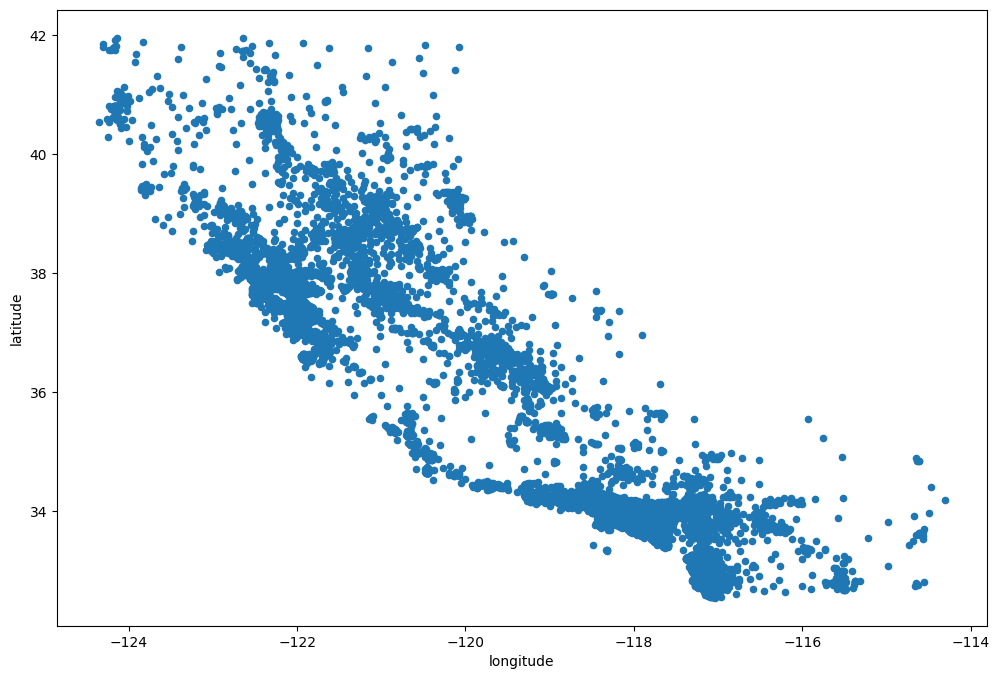

In [4]:
df_train.plot(kind="scatter", x="longitude", y="latitude", figsize=(12, 8));

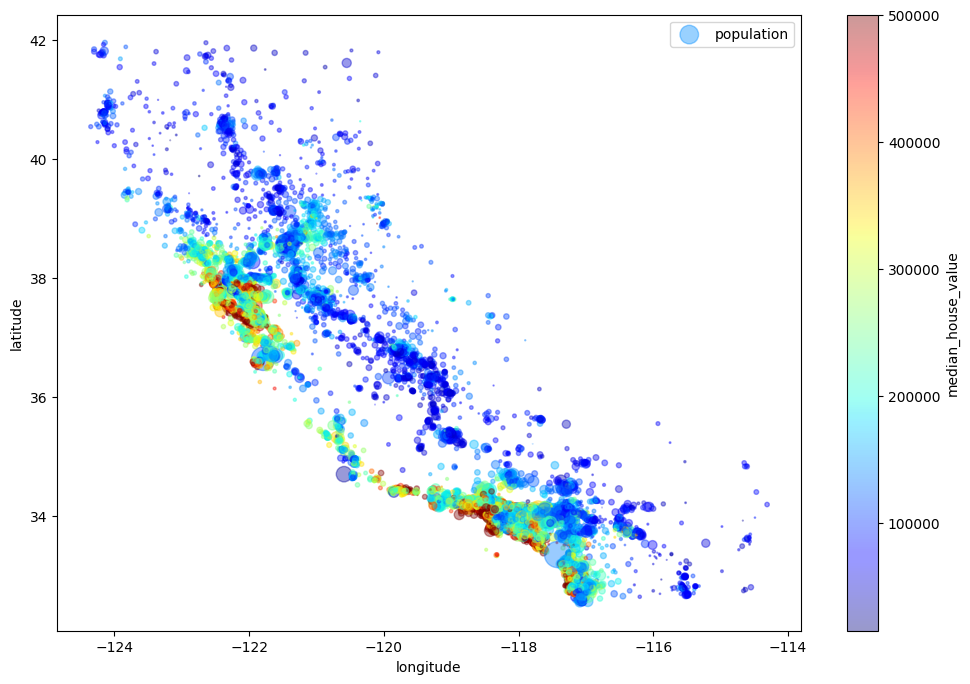

In [5]:
df_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=df_train["population"]/100, label="population", figsize=(12, 8), c="median_house_value",
    cmap=plt.get_cmap("jet"), colorbar=True, sharex=False
)
plt.legend();

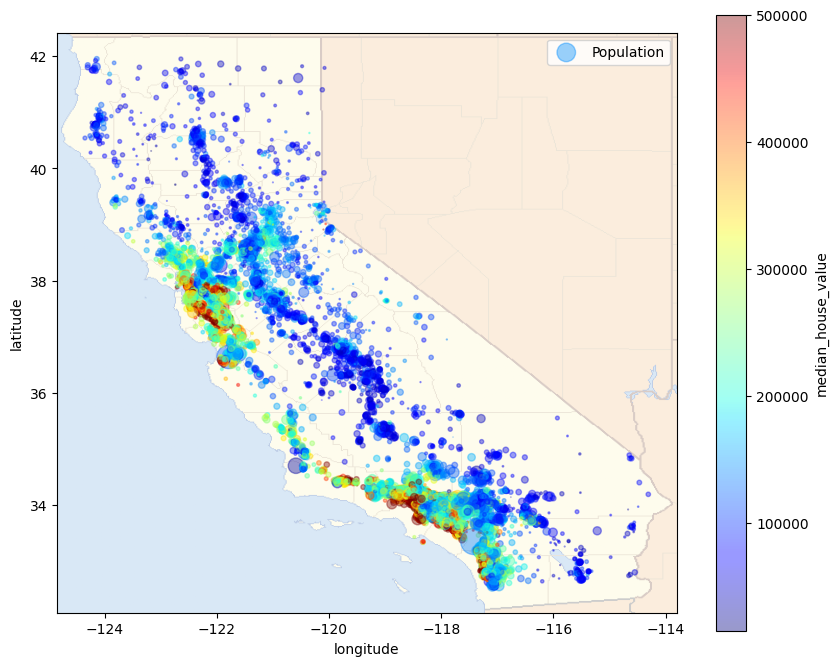

In [6]:
plot_df_on_california(df_train, CALIFORNIA_PATH)

In [7]:
ocean_proximity_value_counts = df_train["ocean_proximity"].value_counts()
ocean_proximity_value_counts

ocean_proximity
<1H OCEAN     8103
INLAND        5848
NEAR OCEAN    2397
NEAR BAY      2036
ISLAND           5
Name: count, dtype: int64

In [8]:
median_house_values_by_proximity = df_train.groupby("ocean_proximity")["median_house_value"].median()
median_house_values_by_proximity

ocean_proximity
<1H OCEAN     215700.0
INLAND        108550.0
ISLAND        414700.0
NEAR BAY      233150.0
NEAR OCEAN    228200.0
Name: median_house_value, dtype: float64

In [9]:
def filter_df_by_proximity(df, proximity):
    return df.loc[df["ocean_proximity"] == proximity]

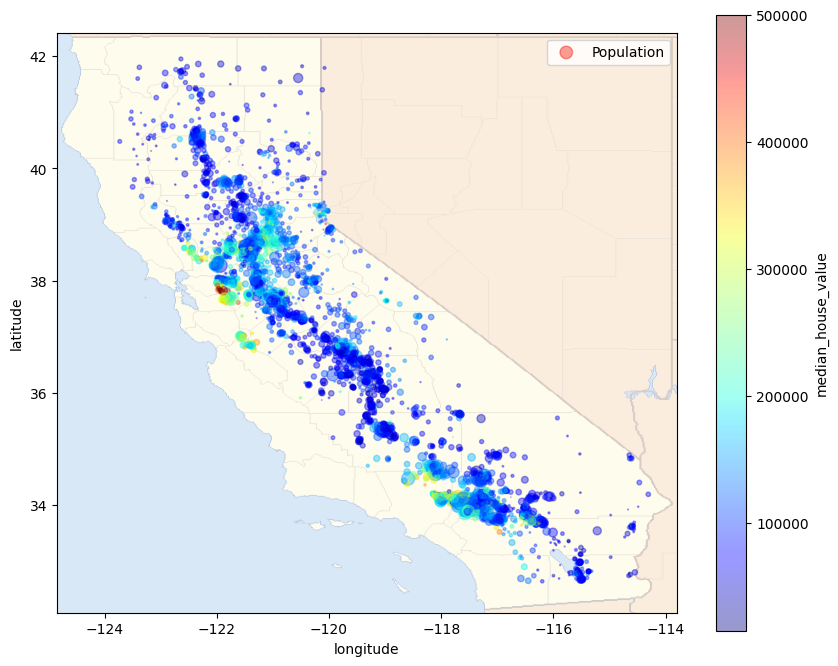

In [10]:
plot_df_on_california(filter_df_by_proximity(df_train, "INLAND"), CALIFORNIA_PATH)

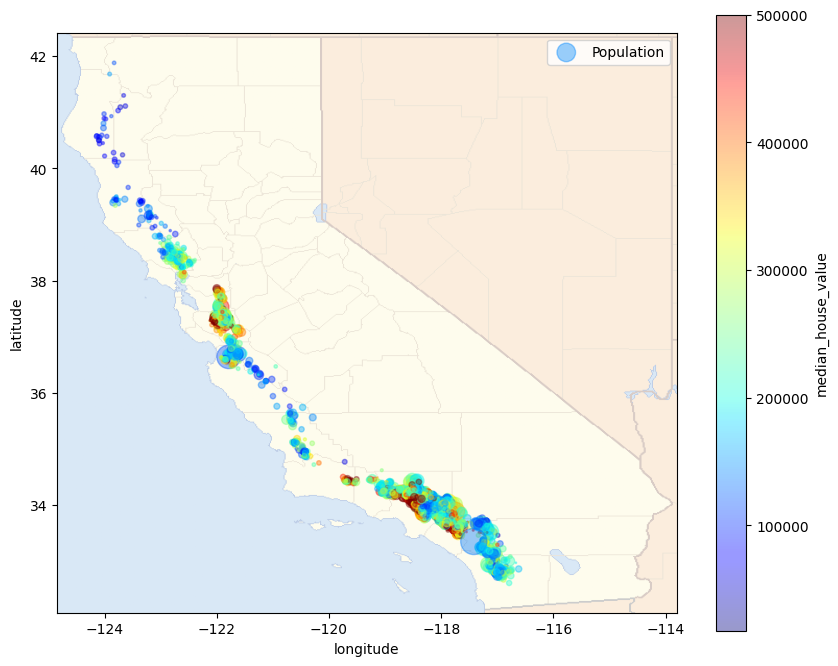

In [11]:
plot_df_on_california(filter_df_by_proximity(df_train, "<1H OCEAN"), CALIFORNIA_PATH)

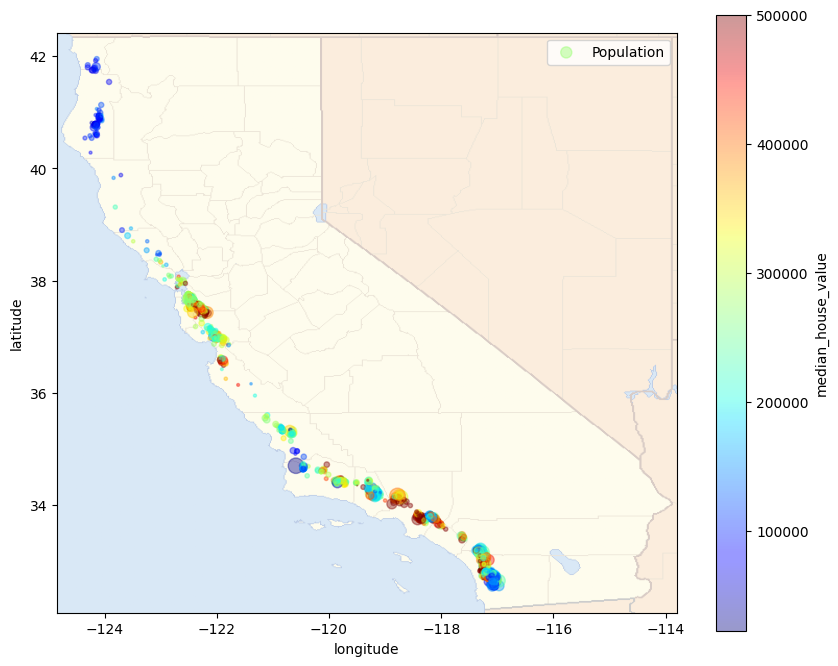

In [12]:
plot_df_on_california(filter_df_by_proximity(df_train, "NEAR OCEAN"), CALIFORNIA_PATH)

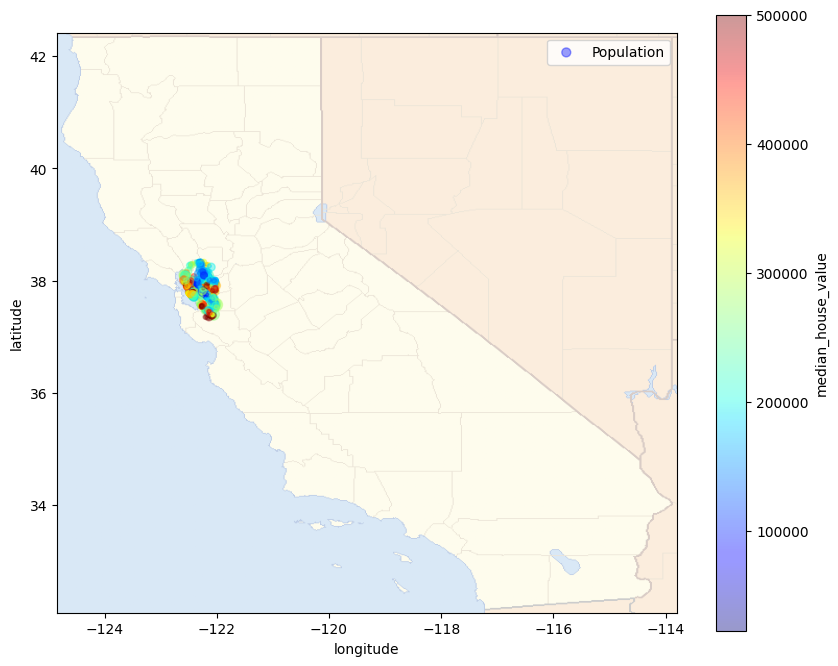

In [13]:
plot_df_on_california(filter_df_by_proximity(df_train, "NEAR BAY"), CALIFORNIA_PATH)

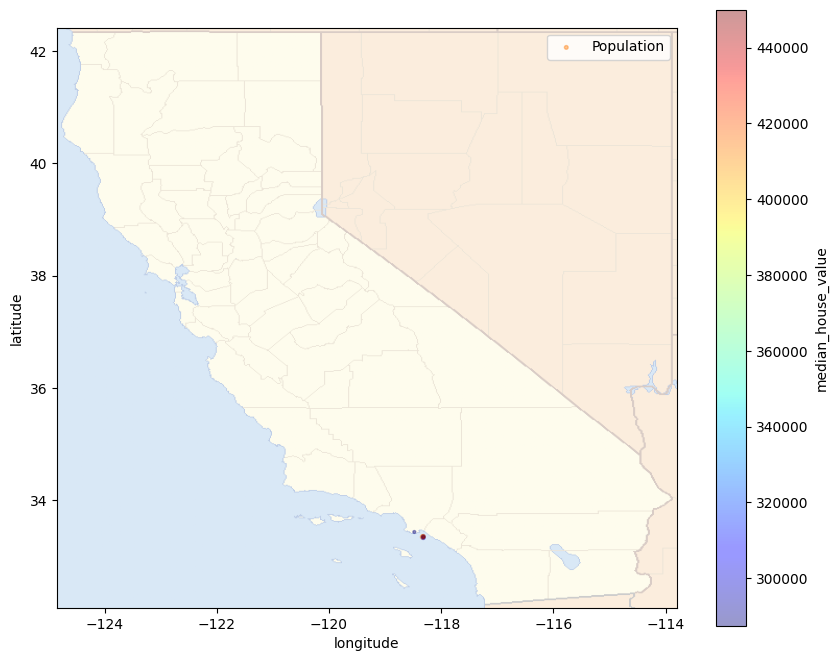

In [14]:
plot_df_on_california(filter_df_by_proximity(df_train, "ISLAND"), CALIFORNIA_PATH)

In [15]:
df_train = df_train.drop(filter_df_by_proximity(df_train, "ISLAND").index)
df_test = df_test.drop(filter_df_by_proximity(df_test, "ISLAND").index)

In [16]:
def predict_by_ocean_proximity(df, median_house_values_by_proximity):
    df["ocean_proximity_prediction"] = df["ocean_proximity"].apply(
        lambda x: median_house_values_by_proximity[x]
    )
    return df

In [17]:
df_train = predict_by_ocean_proximity(df_train, median_house_values_by_proximity)
df_test = predict_by_ocean_proximity(df_test, median_house_values_by_proximity)
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_prediction
11242,-117.93,33.74,15.0,1206.0,282.0,677.0,270.0,3.9219,142600.0,<1H OCEAN,215700.0
987,-121.72,37.70,17.0,1671.0,352.0,729.0,252.0,6.1023,450000.0,INLAND,108550.0
8052,-118.11,33.83,36.0,1462.0,233.0,664.0,220.0,5.1171,225300.0,<1H OCEAN,215700.0
6699,-118.15,34.11,52.0,1746.0,330.0,704.0,306.0,3.7895,364800.0,<1H OCEAN,215700.0
253,-122.21,37.77,52.0,745.0,153.0,473.0,149.0,2.6765,88800.0,NEAR BAY,233150.0


In [18]:
# df_train.corr()["median_house_value"].abs().sort_values(ascending=False)

ValueError: could not convert string to float: '<1H OCEAN'

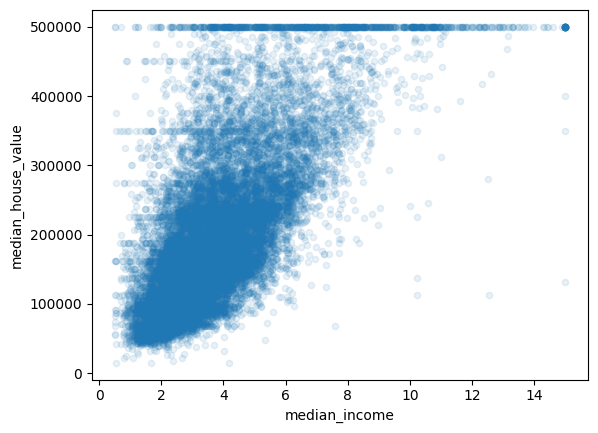

In [19]:
df_train.plot(
    kind="scatter",
    x="median_income",
    y="median_house_value",
    alpha=0.1
);

In [20]:
def engineer_features(df):
    df["ratio_bedrooms"] = df["total_bedrooms"] / df["total_rooms"]
    df["people_per_household"] = df["population"] / df["households"]
    return df

In [21]:
df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

In [22]:
df_train.corr()["median_house_value"].abs().sort_values(ascending=False)

ValueError: could not convert string to float: '<1H OCEAN'